In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

# Add line profiler
%load_ext line_profiler

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib.colorbar import ColorbarBase

from IPython.display import display, HTML

from enum import Enum
import subprocess
import time
import os
import gc
import datetime
import importlib
import logging
import netCDF4
import json

import pycuda.driver as cuda
import pycuda.compiler

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from GPUSimulators import Common, IPythonMagic
from GPUSimulators.EE2D_KP07_dimsplit import EE2D_KP07_dimsplit
from GPUSimulators.helpers import InitialConditions, Visualization

In [2]:
%setup_logging --out test_schemes.log

Console logger using level INFO
File logger using level DEBUG to test_schemes.log
Python version 3.6.7 |Anaconda custom (64-bit)| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]


In [3]:
%cuda_context_handler --no_autotuning my_context 

Registering my_context in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using 'GeForce 840M' GPU
Created context handle <306858187648>
Using CUDA cache dir c:\Users\anbro\Documents\projects\GPUSimulators\GPUSimulators\cuda_cache


In [4]:
#Set large figure sizes as default
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('animation', bitrate=1800)

In [5]:
def plotVars(rho, rho_u, rho_v, E):
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(rho, origin='bottom')
    plt.colorbar(orientation='horizontal', pad=0.02, shrink=0.9)

    plt.subplot(1,4,2)
    plt.imshow(rho_u, origin='bottom')
    plt.colorbar(orientation='horizontal', pad=0.02, shrink=0.9)

    plt.subplot(1,4,3)
    plt.imshow(rho_v, origin='bottom')
    plt.colorbar(orientation='horizontal', pad=0.02, shrink=0.9)

    plt.subplot(1,4,4)
    plt.imshow(E, origin='bottom')
    plt.colorbar(orientation='horizontal', pad=0.02, shrink=0.9)

In [6]:
def runSimulation(outfile, t_end, sim_args):
    with Common.Timer("construct") as t:
        sim = EE2D_KP07_dimsplit(**sim_args)
    print("Constructed in " + str(t.secs) + " seconds")

    #Create netcdf file and simulate
    with Common.DataDumper(outfile, mode='w', clobber=False) as outdata:
        outdata.ncfile.createDimension('time', None)
        outdata.ncfile.createDimension('x', sim.nx)
        outdata.ncfile.createDimension('y', sim.ny)

        #Create variables
        outdata.time_var  = outdata.ncfile.createVariable('time', np.dtype('float32').char, 'time')
        outdata.x_var     = outdata.ncfile.createVariable('x',    np.dtype('float32').char, 'x')
        outdata.y_var     = outdata.ncfile.createVariable('y',    np.dtype('float32').char, 'y')
        outdata.rho_var   = outdata.ncfile.createVariable('rho',   np.dtype('float32').char, ('time', 'y', 'x'), zlib=True, least_significant_digit=3)
        outdata.rho_u_var = outdata.ncfile.createVariable('rho_u', np.dtype('float32').char, ('time', 'y', 'x'), zlib=True, least_significant_digit=3)
        outdata.rho_v_var = outdata.ncfile.createVariable('rho_v', np.dtype('float32').char, ('time', 'y', 'x'), zlib=True, least_significant_digit=3)
        outdata.E_var     = outdata.ncfile.createVariable('E',     np.dtype('float32').char, ('time', 'y', 'x'), zlib=True, least_significant_digit=3)
        
        #Create attributes
        def toJson(in_dict):
            out_dict = in_dict.copy()

            for key in out_dict:
                if isinstance(out_dict[key], np.ndarray):
                    out_dict[key] = out_dict[key].tolist()
                else:
                    try:
                        json.dumps(out_dict[key])
                    except:
                        out_dict[key] = str(out_dict[key])

            return json.dumps(out_dict)
        outdata.ncfile.created = time.ctime(time.time())
        outdata.ncfile.sim_args = toJson(sim_args)

        outdata.x_var[:] = np.linspace(0, sim.nx*sim.dx, sim.nx)
        outdata.y_var[:] = np.linspace(0, sim.ny*sim.dy, sim.ny)

        progress_printer = Common.ProgressPrinter(n_save, print_every=10)
        print("Simulating to t={:f}. Estimated {:d} timesteps (dt={:f})".format(t_end, int(t_end / sim.dt), sim.dt))
        for i in range(n_save+1):
            #Sanity check simulator
            try:
                sim.check()
            except AssertionError as e:
                print("Error after {:d} steps (t={:f}: {:s}".format(sim.simSteps(), sim.simTime(), str(e)))
                return outdata.filename

            #Simulate
            if (i > 0):
                sim.simulate(t_end/n_save)

            #Save to file
            #rho = sim.u0[0].download(sim.stream)
            rho, rho_u, rho_v, E = sim.download()
            outdata.time_var[i] = sim.simTime()
            outdata.rho_var[i, :] = rho
            outdata.rho_u_var[i, :] = rho_u
            outdata.rho_v_var[i, :] = rho_v
            outdata.E_var[i, :] = E

            #Write progress to screen
            print_string = progress_printer.getPrintString(i)
            if (print_string):
                print(print_string)

    return outdata.filename   

In [7]:
class VisType(Enum):
    Schlieren = 0
    Density = 1

def createAnimation(infile, vis_type, vmin, vmax, save_anim=False, cmap=plt.cm.coolwarm, fig_args=None):
    fig = plt.figure(**fig_args)
    
    with Common.DataDumper(infile, 'r') as indata:
        time = indata.ncfile.variables['time'][:]
        x = indata.ncfile.variables['x'][:]
        y = indata.ncfile.variables['y'][:]
        rho = indata.ncfile.variables['rho'][0]
        rho_u = indata.ncfile.variables['rho_u'][0]
        rho_v = indata.ncfile.variables['rho_v'][0]
        
        created = indata.ncfile.created
        sim_args = json.loads(indata.ncfile.sim_args)
        for key in sim_args:
            if isinstance(sim_args[key], list):
                sim_args[key] = "[...]"
        num_frames = len(time)
        print("{:s} created {:s} contains {:d} timesteps".format(infile, created, num_frames))
        print("Simulator arguments: \n", sim_args)

        ax1 = fig.gca()
        extents = [0, x.max(), 0, y.max()]
        
        if (vis_type == VisType.Schlieren):
            im = ax1.imshow(Visualization.genColors(rho, rho_u, rho_v, cmap, vmax, vmin), origin='bottom', extent=extents, cmap='gray', vmin=0.0, vmax=1.0)
            fig.suptitle("Schlieren / vorticity at t={:.2f}".format(time[0]))
        elif (vis_type == VisType.Density):
            im = ax1.imshow(rho, origin='bottom', extent=extents, cmap=cmap, vmin=vmin, vmax=vmax)
            fig.suptitle("Density at t={:.2f}".format(time[0]))
        else:
            assert False, "Wrong vis_type"

        #Create colorbar
        from matplotlib.colors import Normalize
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax1)
        ax2 = divider.append_axes("right", size=0.1, pad=0.05)
        cb1 = ColorbarBase(ax2, cmap=cmap,
                            norm=Normalize(vmin=vmin, vmax=vmax),
                            orientation='vertical')
        
        #Label colorbar
        if (vis_type == VisType.Schlieren):
            cb1.set_label('Vorticity')
        elif (vis_type == VisType.Density):
            cb1.set_label('Density')

        progress_printer = Common.ProgressPrinter(num_frames, print_every=5)
        
        def animate(i):
            rho = indata.ncfile.variables['rho'][i]
            rho_u = indata.ncfile.variables['rho_u'][i]
            rho_v = indata.ncfile.variables['rho_v'][i]
            
            if (vis_type == VisType.Schlieren):
                im.set_data(Visualization.genColors(rho, rho_u, rho_v, cmap, vmax, vmin))
                fig.suptitle("Schlieren / vorticity at t={:.2f}".format(time[i]))
            elif (vis_type == VisType.Density):
                im.set_data(rho) 
                fig.suptitle("Density at t={:.2f}".format(time[i]))
            
            #Write progress to screen
            print_string = progress_printer.getPrintString(i)
            if (print_string):
                print(print_string)

        anim = animation.FuncAnimation(fig, animate, interval=50, frames=range(num_frames))
        plt.close()

        if (save_anim):
            root, _ = os.path.splitext(infile)
            movie_outpath = os.path.abspath(root + ".mp4")
            if (os.path.isfile(movie_outpath)):
                print("Reusing previously created movie " + movie_outpath)
            else:
                print("Creating movie " + movie_outpath)
                #from matplotlib.animation import FFMpegFileWriter
                #writer = FFMpegFileWriter(fps=25)
                from matplotlib.animation import FFMpegWriter
                writer = FFMpegWriter(fps=25)
                anim.save(movie_outpath, writer=writer)
            display(HTML("""
            <div align="middle">
            <video width="80%" controls>
                <source src="{:s}" type="video/mp4">
            </video>
            </div>
            """.format(movie_outpath)))
        else:
            #plt.rcParams["animation.html"] = "html5"
            plt.rcParams["animation.html"] = "jshtml"
            display(anim)

# Shock-bubble

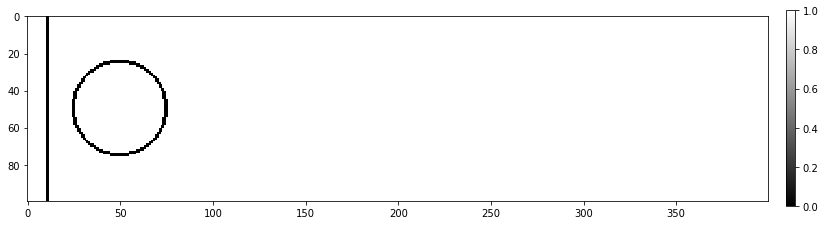

In [8]:
nx = 400
arguments = InitialConditions.genShockBubble(nx, nx//4, 1.4)
plt.figure()
plt.imshow(Visualization.genSchlieren(arguments['rho']), cmap='gray')
plt.colorbar(orientation='vertical', aspect=20, pad=0.02, shrink=0.3)

In [9]:
nx = 800#1600
ny = nx//4
g = 0.0
gamma = 1.4
t_end = 0.5#3.0
n_save = 20#500
outfile = "data/euler_shock-bubble.nc"
outdata = None

arguments = InitialConditions.genShockBubble(nx, ny, gamma)
arguments['context'] = my_context
outfile = runSimulation(outfile, t_end, arguments)

Writing output to c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc
Opening c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc
Keyword arguments: {'mode': 'w', 'clobber': False}


Constructed in 1.875434160232544 seconds
Simulating to t=0.500000. Estimated 1699 timesteps (dt=0.000294)


Closing c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc


In [10]:
#outfile = 'data/euler_shock-bubble_0008.nc'
createAnimation(outfile, vis_type=VisType.Schlieren, vmin=-0.2, vmax=0.2, cmap=plt.cm.RdBu, save_anim=False, fig_args={'figsize':(16, 5)})

Writing output to c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc
Opening c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc
Arguments: ('r',)
Closing c:\Users\anbro\Documents\projects\GPUSimulators\data\euler_shock-bubble_0006.nc
Exception caught: Resetting to CUDA context my_context
Traceback (most recent call last):
  File "c:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ddea935f97e0>", line 2, in <module>
    createAnimation(outfile, vis_type=VisType.Schlieren, vmin=-0.2, vmax=0.2, cmap=plt.cm.RdBu, save_anim=False, fig_args={'figsize':(16, 5)})
  File "<ipython-input-7-4893a31896f1>", line 18, in createAnimation
    for key in sim_args:
RuntimeError: dictionary changed size during iteration
Popping <306858187648>
Pushing <306858187648>


RuntimeError: dictionary changed size during iteration

<Figure size 1152x360 with 0 Axes>

# Kelvin-Helmholtz

In [ ]:
nx = 400
arguments = InitialConditions.genKelvinHelmholtz(nx, nx//4, 1.4)

plt.figure()
plt.imshow(arguments['rho'])
plt.colorbar(orientation='vertical', aspect=20, pad=0.02, shrink=0.3)

In [ ]:
nx = 400
ny = nx//2
roughness = 0.125
t_end = 10.0
n_save = 100#1000
outfile = "data/euler_kelvin_helmholtz.nc"
outdata = None

arguments = InitialConditions.genKelvinHelmholtz(nx, ny, gamma, roughness)
arguments['context'] = my_context
outfile = runSimulation(outfile, t_end, arguments)

In [ ]:
#outfile='data/euler_kelvin_helmholtz_0012.nc'
createAnimation(outfile, vis_type=VisType.Density, vmin=1.0, vmax=2.0, save_anim=False, fig_args={'figsize':(16, 9)})

# Rayleigh-Taylor

* Liska and Wendroff, COMPARISON OF SEVERAL DIFFERENCE SCHEMES ON 1D AND 2D TEST PROBLEMS FOR THE EULER EQUATIONS, http://www-troja.fjfi.cvut.cz/~liska/CompareEuler/compare8.pdf
* https://www.astro.princeton.edu/~jstone/Athena/tests/rt/rt.html
* 

In [ ]:
nx = 400
arguments = InitialConditions.genRayleighTaylor(nx, nx*3, 1.4, version=0)
plotVars(arguments['rho'], arguments['rho_u'], arguments['rho_v'], arguments['E'])

In [ ]:
nx = 151
ny = nx*3
g = 0.1
gamma = 1.4
t_end = 30
n_save = 300
outfile = "data/euler_rayleigh-taylor.nc"
outdata = None

arguments = InitialConditions.genRayleighTaylor(nx, ny, gamma)
arguments['context'] = my_context
outfile = runSimulation(outfile, t_end, arguments)

In [ ]:
#outfile = 'data/euler_rayleigh-taylor_0007.nc'
createAnimation(outfile, vis_type=VisType.Density, vmin=1, vmax=2, cmap=plt.cm.coolwarm, save_anim=False, fig_args={'figsize':(3.4, 8)})